In [11]:
import tensorflow as tf
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau

In [12]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
base_dir = 'dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [14]:
train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=20,
                horizontal_flip=True,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                vertical_flip=True,
                fill_mode='nearest',
                validation_split=0.3)

validation_datagen = ImageDataGenerator(rescale = 1.0/255,
                                        validation_split=0.4)

train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(256,256),
        batch_size=5,
        class_mode='categorical',
        subset='training')

validation_generator = validation_datagen.flow_from_directory(
        test_dir, 
        target_size=(256,256), 
        batch_size=5,
        class_mode='categorical',
        subset='validation')

Found 1313 images belonging to 4 classes.
Found 228 images belonging to 4 classes.


In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    ## Change Dense number to Total Class exist
    tf.keras.layers.Dense(4, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 127, 127, 16)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 16)      2320      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 62, 62, 16)       

In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.000003)
                                            
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[learning_rate_reduction])

Epoch 1/50


2022-06-21 21:04:16.834047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - ETA: 0s - loss: 1.0753 - accuracy: 0.5225

2022-06-21 21:04:51.009225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 39s 147ms/step - loss: 1.0753 - accuracy: 0.5225 - val_loss: 0.8344 - val_accuracy: 0.5877 - lr: 0.0010
Epoch 2/50
263/263 [==============================] - 39s 147ms/step - loss: 0.4378 - accuracy: 0.8035 - val_loss: 0.6812 - val_accuracy: 0.6579 - lr: 0.0010
Epoch 3/50
263/263 [==============================] - 38s 146ms/step - loss: 0.2461 - accuracy: 0.8987 - val_loss: 0.3274 - val_accuracy: 0.7763 - lr: 0.0010
Epoch 4/50
263/263 [==============================] - 566s 2s/step - loss: 0.9171 - accuracy: 0.6055 - val_loss: 1.1887 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/50
263/263 [==============================] - ETA: 0s - loss: 0.7741 - accuracy: 0.6794
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
263/263 [==============================] - 39s 146ms/step - loss: 0.7741 - accuracy: 0.6794 - val_loss: 0.5666 - val_accuracy: 0.6579 - lr: 0.0010
Epoch 6/50
263/263 [==============================] - 39s 146m

In [17]:
def eval_plot(history):
    
    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))
    acc_plot, = plt.plot(epochs, acc, 'r')
    val_acc_plot, = plt.plot(epochs, val_acc, 'b')
    plt.title('Training and Validation Accuracy')
    plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])

    # Loss plot
    plt.subplot(1, 2, 2)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    loss_plot, = plt.plot(epochs, loss, 'r')
    val_loss_plot, = plt.plot(epochs, val_loss, 'b')
    plt.title('Training and Validation Loss')
    plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

def evaluate(model):
    
    validation_generator = train_datagen.flow_from_directory(
            test_dir, 
            target_size=(256,256), 
            batch_size=10, 
            class_mode='categorical',
            shuffle = False,
            subset='validation')

    batch_size = 10
    num_of_test_samples = len(validation_generator.filenames)

    Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
    y_pred = np.argmax(Y_pred, axis=1)

    print('\nConfusion Matrix\n')
    print(confusion_matrix(validation_generator.classes, y_pred))


    print('\n\nClassification Report\n')
    target_names = ['GINA', 'MATAHARI', 'SIRAT','ULI']
    print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

def predict_image(image_upload, model = model):
    im = image_upload
    im_array = np.asarray(im)
    im_array = im_array*(1/225)
    im_input = tf.reshape(im_array, shape = [1, 256, 256, 3])

    predict_proba = sorted(model.predict(im_input)[0])[2]
    predict_class = np.argmax(model.predict(im_input))

    print('\n')
    plt.show()
    print("\nImage prediction result: ", predict_label)
    print("Probability: ", round(predict_proba*100,2), "%")
    print('\n')

Found 172 images belonging to 4 classes.


/var/folders/68/ws912nt53sj93j_v0j_wm41r0000gn/T/ipykernel_5162/711828489.py:38: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
2022-06-21 21:52:01.937817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Confusion Matrix

[[36  0  0  7]
 [31 12  0  0]
 [ 0  0 43  0]
 [ 0  0  0 43]]


Classification Report

              precision    recall  f1-score   support

        GINA       0.54      0.84      0.65        43
    MATAHARI       1.00      0.28      0.44        43
       SIRAT       1.00      1.00      1.00        43
         ULI       0.86      1.00      0.92        43

    accuracy                           0.78       172
   macro avg       0.85      0.78      0.75       172
weighted avg       0.85      0.78      0.75       172



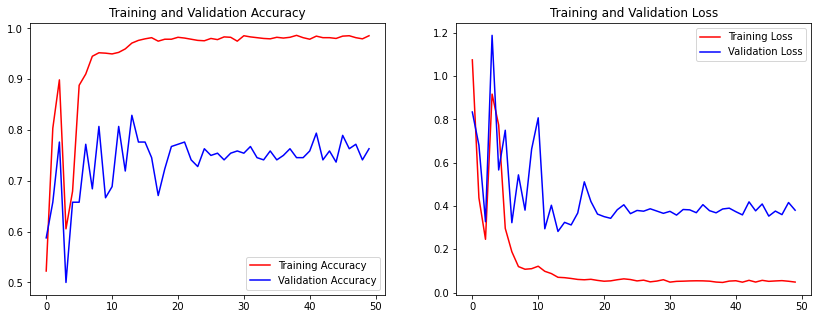

In [18]:
eval_plot(history)
evaluate(model)
